In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt 
import json


In [23]:
orders = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks/2_orders.json")) 
i = 0
print(len(orders))
orders_new = []
for order in orders:
    if i < 20000:
        orders_new.append(order)
    else:
        break
    i += 1

411830


In [22]:
len(orders_new)

20000

In [18]:
#del orders_new[300000:320000]

In [26]:
json.dump(orders_new, open("../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/2_orders.json", "w"))

In [3]:
use_case = "wepastacks"

In [4]:
layout = pd.read_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}/1_layout.csv", header=None, delimiter=",")

In [5]:
layout.dropna(axis=1, how='all', inplace=True)

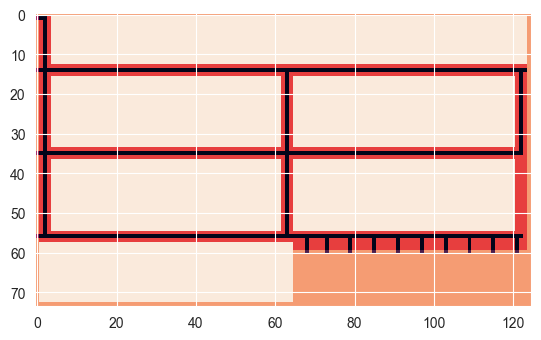

In [6]:
plt.imshow(layout)

In [7]:
def gen_charging_stations(layout, n_cs):
    charging_locs = [len(layout.columns) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    aisle = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[1])
    aisle1 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[2])
    line = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -2 if i == 1 else -5 for i in range(len(layout.columns))}, index=[3])
    aisle2 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i == 2 else -2 for i in range(len(layout.columns))}, index=[4])
    
    layout_new = pd.concat([layout.iloc[:1], aisle, aisle1, line, aisle2, layout.iloc[1:]]).reset_index(drop=True)
    return layout_new

def gen_charging_stations_left(layout, n_cs):
    # Calculate the positions for charging stations
    charging_locs = [len(layout.index) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    
    # Create new columns for the charging stations and aisles
    aisle = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.index))})
    aisle1 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    #line = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -2 if i == 1 else -5 for i in range(len(layout.index))})
    # aisle2 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    # aisle3 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    
    # Concatenate the new columns with the existing layout, preserving the structure
    layout_new = pd.concat([
        layout.iloc[:, :1],  # First column of original layout
        pd.DataFrame({0: aisle, 1: aisle1}),  # New columns
        layout.iloc[:, 2:]  # Rest of the original layout
    ], axis=1)
    
    # Reset and rename the columns
    layout_new.columns = range(len(layout_new.columns))
    
    return layout_new
    

In [8]:
if use_case == "wepastacks":
    layout_new = gen_charging_stations(layout, 1)
elif use_case == "crossstacks":
    layout_new = gen_charging_stations_left(layout, 4)

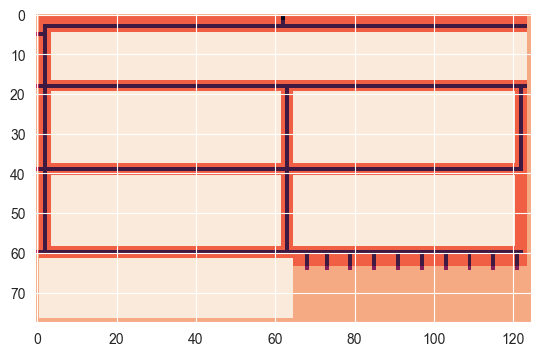

In [9]:
plt.imshow(layout_new)

In [10]:
layout_new.to_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}_bm/1_layout.csv", header=None, index=False)